---
# 자치구 및 행정동 평균 소득과 따릉이 이용량의 상관관계 분석

- 이 노트북에서는 **`2024 자치구별 소득평균.csv`**, **`rental_net_hourly_gu`**,  
  **`2024 행정동별 소득평균.csv`**, **`station`** 데이터를 활용하여  
  서울시 자치구 및 행정동의 **평균 소득**과 **따릉이 이용량** 간의 상관관계를 분석합니다.
- 자치구 단위에서는 **Pearson 상관계수**와 **회귀선 시각화**를 활용하며,  
  행정동 단위 데이터도 MySQL에 저장하여 향후 분석을 위한 기반을 마련합니다.
---


공공데이터 소득 평균 데이터 테이블 생성

In [ ]:
import pandas as pd
import mysql.connector

file_path = "/home/kbj/Downloads/2024 자치구별 소득평균.csv"

df = pd.read_csv(file_path)

df.columns = ['gu_name', 'avg_monthly_income']

conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS income_avg_gu")
cursor.execute("""
CREATE TABLE income_avg_gu (
    gu_name VARCHAR(20),
    avg_monthly_income INT
)
""")

for _, row in df.iterrows():
    cursor.execute(
        "INSERT INTO income_avg_gu (gu_name, avg_monthly_income) VALUES (%s, %s)",
        (row['gu_name'], int(row['avg_monthly_income']))
    )

conn.commit()
cursor.close()
conn.close()

print(" 데이터가 'income_avg_gu' 테이블에 성공적으로 삽입되었습니다.")


✅ 데이터가 'income_avg_gu' 테이블에 성공적으로 삽입되었습니다.


2024년 자치구별 월평균 소득 시각화

/tmp/ipykernel_46989/2435300067.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/tmp/ipykernel_46989/2435300067.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="avg_monthly_income", y="gu_name", palette="YlGnBu")


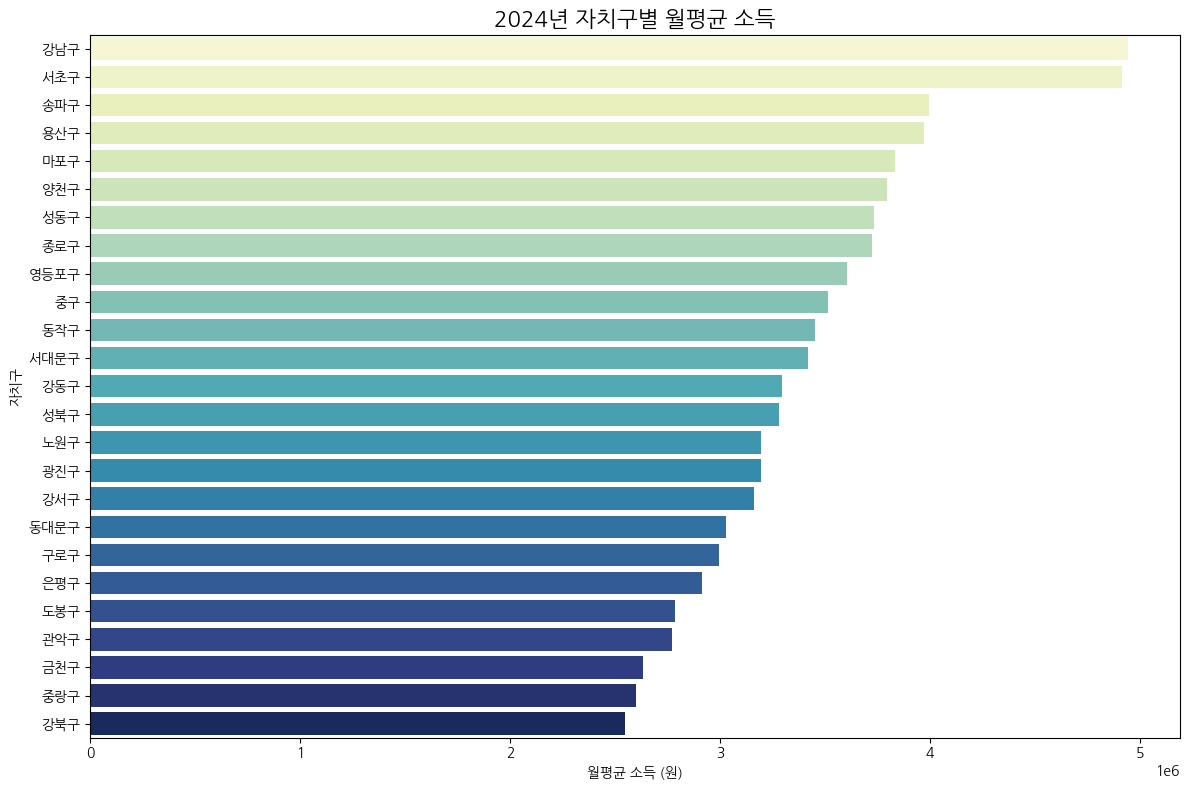

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib 

conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

query = "SELECT gu_name, avg_monthly_income FROM income_avg_gu"
df = pd.read_sql(query, conn)
conn.close()

df = df.sort_values(by="avg_monthly_income", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df, x="avg_monthly_income", y="gu_name", palette="YlGnBu")

plt.title("2024년 자치구별 월평균 소득", fontsize=16)
plt.xlabel("월평균 소득 (원)")
plt.ylabel("자치구")
plt.tight_layout()
plt.show()

자치구별 평균 소득 vs 따릉이 대여 수 상관관계

/tmp/ipykernel_46989/4010371898.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_income = pd.read_sql(query_income, conn)
/tmp/ipykernel_46989/4010371898.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rental = pd.read_sql(query_rental, conn)


📌 상관계수 (Pearson r): 0.1674


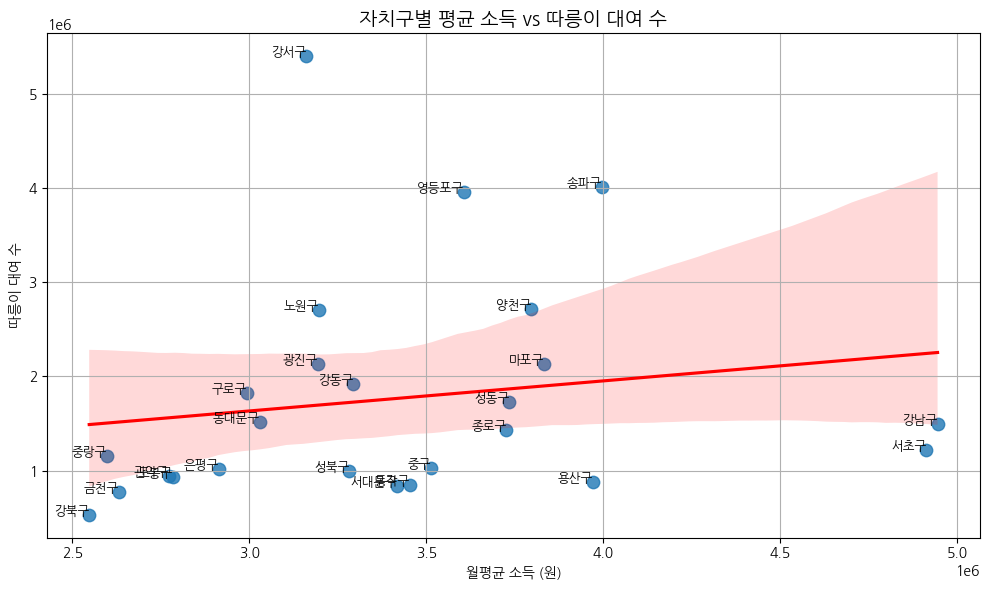

In [ ]:
from scipy.stats import pearsonr


conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

query_income = "SELECT gu_name, avg_monthly_income FROM income_avg_gu"
df_income = pd.read_sql(query_income, conn)

query_rental = """
SELECT station_gu AS gu_name, SUM(rental_count) AS total_rentals
FROM rental_net_hourly_gu
GROUP BY station_gu
"""
df_rental = pd.read_sql(query_rental, conn)

conn.close()

merged = pd.merge(df_income, df_rental, on="gu_name")

corr, _ = pearsonr(merged["avg_monthly_income"], merged["total_rentals"])
print(f" 상관계수 (Pearson r): {corr:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(
    data=merged,
    x="avg_monthly_income",
    y="total_rentals",
    scatter_kws={"s": 80},
    line_kws={"color": "red"}
)

for i in range(len(merged)):
    plt.text(
        merged["avg_monthly_income"][i],
        merged["total_rentals"][i],
        merged["gu_name"][i],
        fontsize=9,
        ha='right'
    )

plt.title(f"자치구별 평균 소득 vs 따릉이 대여 수", fontsize=14)
plt.xlabel("월평균 소득 (원)")
plt.ylabel("따릉이 대여 수")
plt.grid(True)
plt.tight_layout()
plt.show()

동별로 소득평균 데이터 테이블 생성

In [ ]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine

df_income_dong = pd.read_csv("/home/kbj/Downloads/2024 행정동별 소득평균.csv")
df_income_dong.columns = ["dong_name", "avg_income"]  


host="host",
port=0000,
user="user",
password="password",
database="project1"

engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")

df_income_dong.to_sql("income_avg_dong", con=engine, if_exists="replace", index=False)

print(" income_avg_dong 테이블로 업로드 완료")


✅ income_avg_dong 테이블로 업로드 완료


In [ ]:
import pandas as pd
import mysql.connector

conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

df_station = pd.read_sql("SELECT * FROM station", conn)
df_station.to_csv("station_table.csv", index=False, encoding="utf-8-sig")

print(" 'station_table.csv' 파일로 저장 완료")

conn.close()


✅ 'station_table.csv' 파일로 저장 완료


/tmp/ipykernel_46989/705469167.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_station = pd.read_sql("SELECT * FROM station", conn)


동별 평균 소득 vs 따릉이 대여 수 상관계수

/tmp/ipykernel_57219/3210284989.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_income = pd.read_sql("SELECT * FROM income_avg_dong", conn)
/tmp/ipykernel_57219/3210284989.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rental = pd.read_sql("SELECT * FROM rental_station", conn)
/tmp/ipykernel_57219/3210284989.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_station = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station_b", conn)


📌 상관계수 (r): 0.18


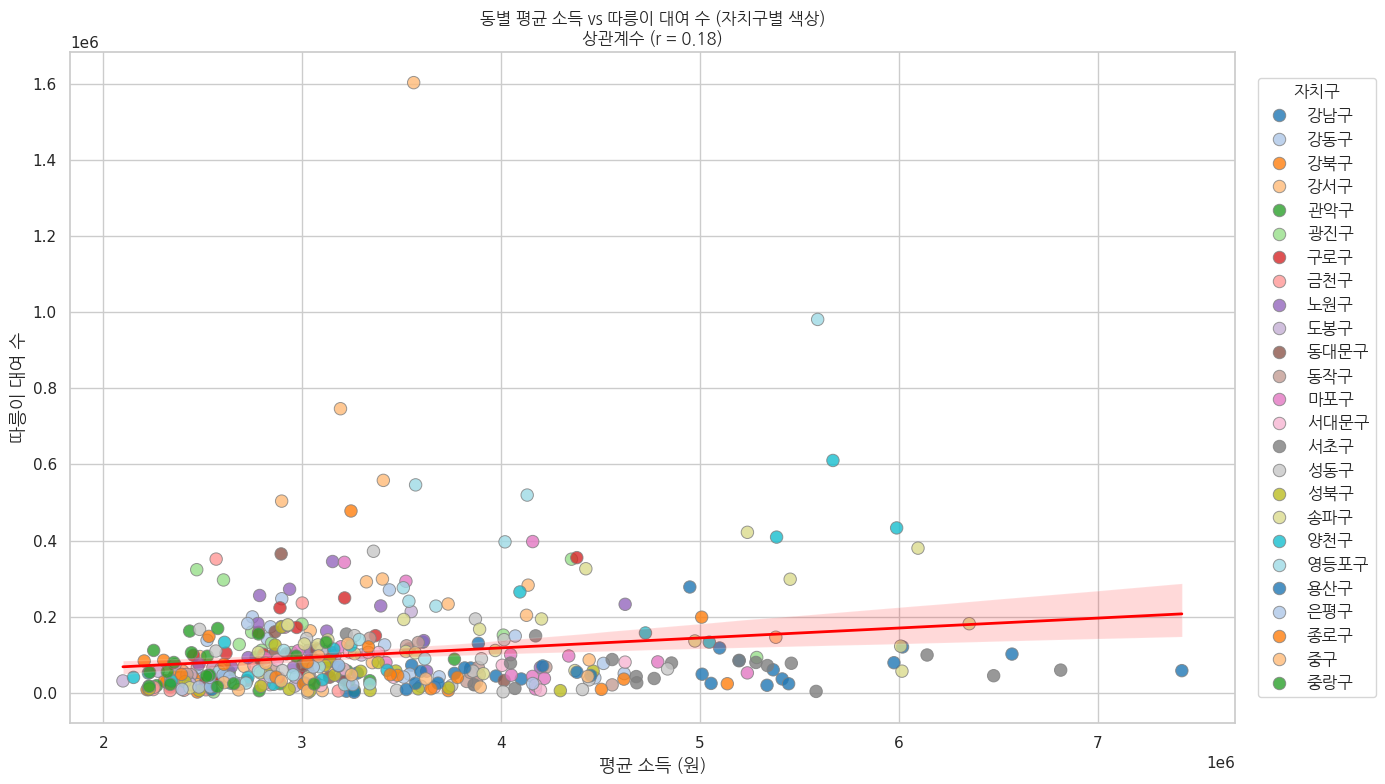

In [ ]:

font_path = "/home/kbj/Downloads/godic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)
df_income = pd.read_sql("SELECT * FROM income_avg_dong", conn)
df_rental = pd.read_sql("SELECT * FROM rental_station", conn)
df_station = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station_b", conn)
conn.close()

df_merge = pd.merge(df_rental, df_station, left_on="rental_station_id", right_on="station_id")

df_rental_by_dong = df_merge.groupby(["station_gu", "station_dong"])["total_rental_count"].sum().reset_index()
df_rental_by_dong.columns = ["gu_name", "dong_name", "total_rental_count"]

df_all = pd.merge(df_rental_by_dong, df_income, on="dong_name")

corr, _ = pearsonr(df_all["avg_income"], df_all["total_rental_count"])
print(f" 상관계수 (r): {corr:.2f}")

sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=df_all,
    x="avg_income",
    y="total_rental_count",
    hue="gu_name",
    palette="tab20",
    s=80,
    alpha=0.8,
    edgecolor="gray"
)

sns.regplot(
    data=df_all,
    x="avg_income",
    y="total_rental_count",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

plt.title(f"동별 평균 소득 vs 따릉이 대여 수 (자치구별 색상)\n상관계수 (r = {corr:.2f})",
          fontsize=16, fontweight="bold", fontproperties=font_prop)
plt.xlabel("평균 소득 (원)", fontsize=13, fontproperties=font_prop)
plt.ylabel("따릉이 대여 수", fontsize=13, fontproperties=font_prop)

legend = plt.legend(title="자치구", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.)
legend.get_title().set_fontproperties(font_prop)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)

plt.tight_layout()
plt.show()


동별 생활인구 vs 따릉이 대여 수 상관계수

/tmp/ipykernel_18569/3111000353.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rental = pd.read_sql("SELECT * FROM rental_station", conn)
/tmp/ipykernel_18569/3111000353.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_station = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station", conn)
/tmp/ipykernel_18569/3111000353.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_life = pd.read_sql("SELECT dong_name, avg_population FROM district_summary_gu", conn)


📌 상관계수 (r): 0.32


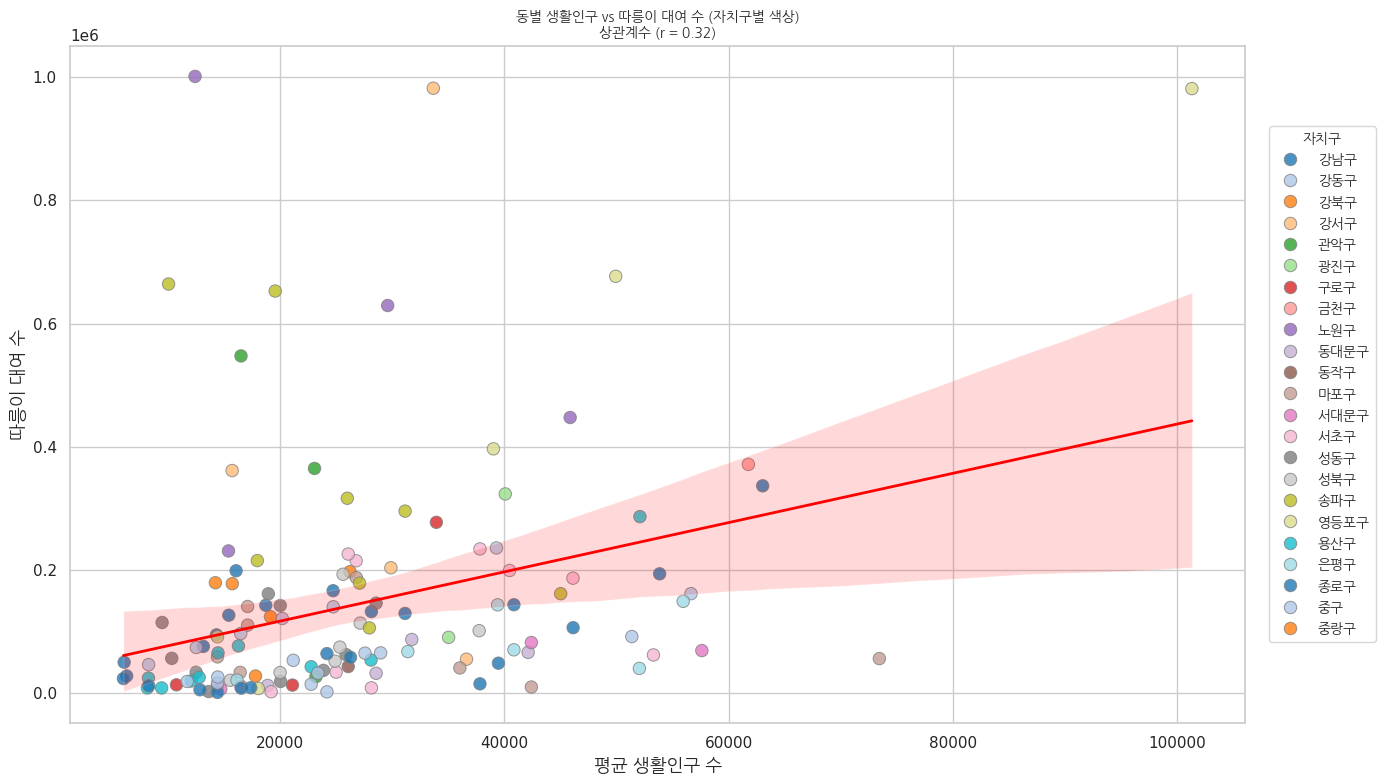

In [ ]:
font_path = "/home/kbj/Downloads/godic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

conn = mysql.connector.connect(
    host="host",
    port=0000,
    user="user",
    password="password",
    database="project1"
)

df_rental = pd.read_sql("SELECT * FROM rental_station", conn)
df_station = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station", conn)
df_life = pd.read_sql("SELECT dong_name, avg_population FROM district_summary_gu", conn)
conn.close()

df_merge = pd.merge(df_rental, df_station, left_on="rental_station_id", right_on="station_id")

df_rental_by_dong = df_merge.groupby(["station_gu", "station_dong"])["total_rental_count"].sum().reset_index()
df_rental_by_dong.columns = ["gu_name", "dong_name", "total_rental_count"]

df_all = pd.merge(df_rental_by_dong, df_life, on="dong_name")

corr, _ = pearsonr(df_all["avg_population"], df_all["total_rental_count"])
print(f"📌 상관계수 (r): {corr:.2f}")

sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=df_all,
    x="avg_population",
    y="total_rental_count",
    hue="gu_name",
    palette="tab20",
    s=80,
    alpha=0.8,
    edgecolor="gray"
)

sns.regplot(
    data=df_all,
    x="avg_population",
    y="total_rental_count",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

plt.title(f"동별 생활인구 vs 따릉이 대여 수 (자치구별 색상)\n상관계수 (r = {corr:.2f})",
          fontsize=16, fontweight="bold", fontproperties=font_prop)
plt.xlabel("평균 생활인구 수", fontsize=13, fontproperties=font_prop)
plt.ylabel("따릉이 대여 수", fontsize=13, fontproperties=font_prop)

legend = plt.legend(title="자치구", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.)
legend.get_title().set_fontproperties(font_prop)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)

plt.tight_layout()
plt.show()